# Introduction 

- The categories in are available in tender_categories
- Data that is useful for categorization includes
  - 'tender_details'
  - 'tender_description' 
  - 'boq_items'
  - 'boq_details'
- After going through the features, we chose to combine the columns into a single string before feeding to the model
- Bag of words
  - We used a simple countvectorizer to make vectors based on word frequencies
  - Naive Bayes was used to analyze these vectors
  - Evaluation using the standard accuracy metric suggests that the model is good but when using balanced accuracy we can see that naive bayes does not perform well.
  - This is expected due to the skew in the data
- Word embeddings
  - We use the GoogleNews embedding to create better representations for the words
  - Naive Bayes is applied
  - It is observed that the overall accuracy improved but the balanced accuracy suffered
- Large Language model
  - We used the bert-base-uncased model and fine tuned it with our training data
  - Text classification was carried out on the test set
  - It was discovered that the both accuracy metrics have improved 

## Flow of logic

### Ingesting tenders
- Reading of data into pandas
- Fixing repeated columns
- Checking for uniqueness of information
  - boq_details and boq_items
  - tender_description and tender_details
  - tender_details and boq_details
### Feature engineering
- Creating labels
  - Plotting the skew in data
  - Looking for ways to combine labels
- Dropping additional columns
- Splitting the data into train and test set
### Bag of Word representation
- Representing the text as vectors: Countvectorizer
  - Combining tender_details and boq_details into a single string
  - Tokenizing the string using Spacy tokenizer
    - Training vector which can transform new instances
#### Using Naive Bayes
#### Evaluation
- Evaluation is carried out using the accuracy metric
- Evaluation is carried out using the balanced accuracy metric
- Since balanced accuracy is low, moving to word embeddings to see if there is an improvement
### Word embeddings
- Downloading GoogleNew embedding
- Transforming the train and test features 
#### Using Naive Bayes
- Same as the previous Naive Bayes implementation
#### Evaluation
- Same as the previous Evaluation implementation
### Large Language Model
#### Creating the training and evaluation dataset
- Splitting the dataset for fine tuning of the LLM
#### Tokenization
- Using the BERT tokenizer on the training and evaluation sets
#### Fine Tuning of the mode
- Using google colab to fine tune the model

# Prequisites

!pip install pandas
!pip install scipy
!pip install numpy
!pip install spacy
!pip install matplotlib
!python -m spacy download en_core_web_sm
!pip install scikit-learn
!pip install gensim

# Ingesting Tenders

In [1]:
import pandas as pd

In [2]:
tenders = pd.read_csv(
filepath_or_buffer='data/dataScienceAssignment/tender.csv',\
# This is the file path of the csv
# Get the column names from a header row
na_values='[]',
header=0,
)

In [3]:
tenders.head()

,Unnamed: 0.1,Unnamed: 0,tender_id,tender_description,tender_details,tender_category,boq_items,boq_details,boq_len
0,0,0,ad77c36d-ee5b-415a-917b-f65a81752625,Construction Of Rcc Drain With Cover Slab From...,Construction Of Rcc Drain With Cover Slab From...,Works,"[{'rowNumber': 12, 'itemDescription': 'Dismant...",['Dismantling and removing cement concrete inc...,11
1,1,1,d17ff512-0f4e-4e63-b9c0-4b4c13157f47,Day To Day Upkeeping Of Lawn And Garden At Koy...,Day To Day Upkeeping Of Lawn And Garden At Koy...,Works,"[{'rowNumber': 21, 'itemDescription': 'Shiftin...",['Shifting of Ghamlas from garden to 1 to 10 t...,29
2,2,2,d5d6a926-6dec-473c-b6f4-c195e1c334f2,"P/l Wmb G-ii, 75 Mm Thick Wet Mix Macadam And ...","P/l Wmb G-ii, 75 Mm Thick Wet Mix Macadam And ...",Works,"[{'rowNumber': 12, 'itemDescription': 'Providi...","['Providing , laying, spreading and compacting...",4
3,3,3,67bab7b5-b577-481f-a64f-f52a9e89a13f,Improvement And Biannual Maintenance To Anjang...,Improvement And Biannual Maintenance To Anjang...,Works,"[{'rowNumber': 12, 'itemDescription': 'IMPROVE...",['IMPROVEMENT AND BIANNUAL MAINTENANCE TO ANJA...,1
4,4,4,a47aeaf3-7b4d-4551-8d7e-c0415f65f411,Pre-monsoon Cleaning And Desilting Of,Pre-monsoon Cleaning And Desilting Of Exisitin...,Works,"[{'rowNumber': 18, 'itemDescription': 'GST 12%...","['GST 12%', 'PROVIDING AND OPERATING DUMPER OF...",6


## Fixing the extra index columns 

In [4]:
tenders.loc[tenders['Unnamed: 0.1']!=tenders['Unnamed: 0']]

,Unnamed: 0.1,Unnamed: 0,tender_id,tender_description,tender_details,tender_category,boq_items,boq_details,boq_len


In [5]:
tenders.loc[tenders.index!=tenders['Unnamed: 0']]

,Unnamed: 0.1,Unnamed: 0,tender_id,tender_description,tender_details,tender_category,boq_items,boq_details,boq_len


In [6]:
tenders.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [ ]:
tenders.info()

## BOQ items and details equivalence

In [ ]:
tenders['boq_items'][0]

- Assuming that the quantity, units, rate, amount and '\_class' quantities do not affect the category of the item
- The only important information is the 'itemDescription'
- Observing that the column boq_details also contains similar information

Checking for equivalence of values in 'boq_items' & 'boq_details'

In [9]:
from ast import literal_eval

In [10]:
def boq_items_conv(rowitem):
    """Function to filter the items description from boq_items and add to list
    """
    boq_details = [] # List contain item descriptions
    if rowitem != '[]':
        boqitemslist = literal_eval(rowitem) # Literal evaluation of the bytes to convert to python list
        for item in boqitemslist:
            boq_details.append(item['itemDescription']) # Adding descriptions to the list
    return boq_details

In [ ]:
boq_items_conv(tenders['boq_items'][0])

In [12]:
def boq_details_conv(rowitem):
    """ Function to convert the bytes in boq_details to python list
    """
    if rowitem != '[]':
        test = literal_eval(rowitem)
        return test

In [ ]:
tenders['boq_details'][80:90]

In [ ]:
boq_details_conv(tenders['boq_details'][0])

Listing out rows in which the lists are different

Since there are no such rows. We will drop the 'boq_items'

In [15]:
tenders.drop(columns=['boq_items'], inplace=True)

In [ ]:
tenders.info()

## tender_description and tender_details equivalence

It appears that tender_description and tender_details are also very similar.
Printing the cases, where it is different.

In [ ]:
tenders.loc[tenders['tender_description']!=tenders['tender_details']][['tender_description','tender_details']].info()

In [ ]:
tenders.loc[tenders['tender_description']!=tenders['tender_details']][['tender_description','tender_details']].values

- It is observed that in the 20 cases, tender_description and tender_details don't match
- In these cases, tender_details has a copy of the information in tender_description and a few more details

In [19]:
tenders.drop(columns=['tender_description'], inplace=True)

## tender_details and boq_details

In [ ]:
tenders[['tender_details', 'boq_details']][:5].values

- It appears that the data in both these items are different
- One might want to evaluate the usefulness of joining these two items to make a single column
- For the moment, I am going to fill all the NAN values in boq_details with the values in tender_details

# Feature Engineering

## Labels

Converting the tender_category column a form that can be fed to models

In [21]:
tenders['tender_category'].unique()

array(['Works', 'PERCENTAGE', 'ITEM RATE', nan, 'Services', 'Goods',
       'WORKS', 'SERVICES', 'GOODS'], dtype=object)

The 'nan' objects are not useful and we will drop these rows from further analysis

In [ ]:
tenders.loc[tenders['tender_category'].isna()].count()

This amounts to ~10% of the total data available

In [23]:
tenders.dropna(subset=['tender_category'], inplace=True)

Creating a labels column with normalized categories

In [24]:
tenders['label'] = tenders['tender_category'].map({'Works':0, 'WORKS':0, 'Services': 1, 'SERVICES': 1, 'Goods': 2, 'GOODS': 2, 'ITEM RATE': 3, 'PERCENTAGE': 4})

In [25]:
tenders.drop(columns=['tender_category'], inplace=True)

Checking the spread of the data

In [26]:
import matplotlib.pyplot as plt

<Axes: >

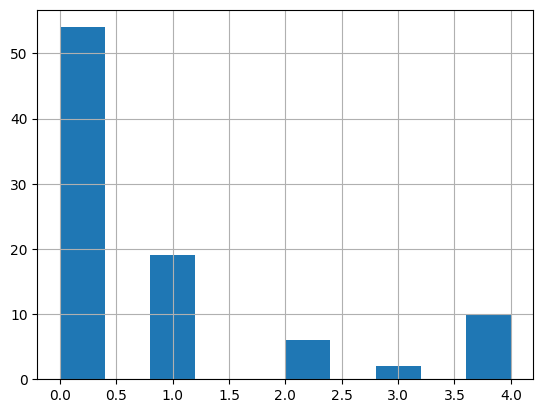

In [27]:
tenders['label'].hist()

Note the skew in the data towards 'Work' and 'Services' categories

In [ ]:
tenders.loc[tenders['label']==3]['boq_details'].values

Checking to see if 'ITEM RATE' can be absorbed in the other categories

In [ ]:
tenders.loc[tenders['label']==4]['boq_details'].values

Checking to see if 'PERCENTAGE' can be absorbed in the other categories

## Features

- tender_id is a unique number with no connection to the category
- boq_len also has no connection with the category

In [30]:
tenders.drop(columns=['tender_id', 'boq_len'], inplace=True)

In [31]:
tenders['boq_details'].fillna('[]',inplace=True)

#### Combining columns to create a single feature string

Ideally I would want to convert the text from tender_details and boq_details to vectors too but we intend to try out different ways of vectorizing them and will postpone to the sections below

1. Creating the function for combining the line items in boq_details into a single string

In [32]:
def boq_details_concat(rowitem):
    """ Function to convert the bytes in boq_details to python list
    """
    if rowitem is not None:
        test = literal_eval(rowitem)
        if test is not None:
            return ' '.join(test)
    else:
        return ''

2. Joining strings to create one common feature string

In [33]:
tenders['features'] = tenders['tender_details'].values + tenders['boq_details'].map(boq_details_concat).values

In [34]:
tenders.drop(columns=['tender_details', 'boq_details'], inplace=True)

In [ ]:
tenders.info()

## Split for testing and training

In [36]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(tenders, test_size=0.2, random_state=1)

# Representation: Bag of words

### Transforming the natural language data

#### Creating count vectors

In [37]:
import spacy
nlp = spacy.load("en_core_web_sm")

/home/sumeetkd/.pyenv/versions/3.11.1/envs/hugface/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
def spacy_tokenizer(document):
    tokens = nlp(document)
    tokens = [token.lemma_.lower() for token in tokens if (
        token.is_stop == False and \
        token.is_punct == False and \
        token.lemma_.strip()!= '')]
    return tokens

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer(input = 'content', tokenizer = spacy_tokenizer)

In [40]:
train_features_td = vector.fit_transform(train_set['features'].values)

/home/sumeetkd/.pyenv/versions/3.11.1/envs/hugface/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [41]:
test_features_td = vector.transform(test_set['features'].values)

# Model selection and prediction

- There could be a relation between the first few words of tender_details and the label. We should try to capture the first few words of the description and use that as features
- To begin with we will try to understand the effectiveness of Naive Bayes

## Model: Naive Bayes

In [42]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [44]:
tenders['label'][1:8].values

array([0, 0, 0, 0, 4, 4, 4])

In [45]:
nb.fit(train_features_td,train_set['label'])

MultinomialNB()

In [46]:
nb.predict(train_features_td[0])

array([1])

In [47]:
train_set['label'][0]

0

## Evaluation

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

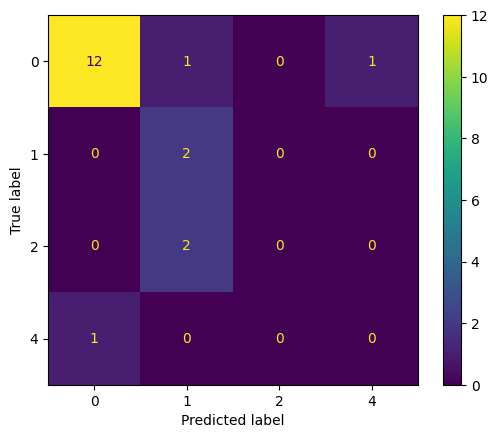

In [49]:
ConfusionMatrixDisplay.from_predictions(test_set['label'],nb.predict(test_features_td))

Evaluation of accuracy could be done using the standard accuracy metric 

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
accuracy_score(test_set['label'],nb.predict(test_features_td))

0.7368421052631579

Being greater than 70%, this seems like an okay result. 

However, we have seen that the other classes are not doing quite well.
A better metric that is able to capture the effectiveness to classify in imbalanced classes is the balanced accuracy

In [52]:
from sklearn.metrics import balanced_accuracy_score

In [53]:
balanced_accuracy_score(test_set['label'],nb.predict(test_features_td))

0.4642857142857143

With balanced accuracy, we can see that we the current model is not doing well and we should be exploring other models

# Representation: Word Embeddings

## Transforming the train and test data

In [67]:
from gensim.models import Word2Vec, KeyedVectors

In [68]:
import numpy as np

Download the model from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g
And unzip it

In [69]:
path_to_model = 'GoogleNews-vectors-negative300.bin'

In [70]:
w2v_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)

In [71]:
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats

In [72]:
train_features_we = embedding_feats(train_set['features'].values)

In [73]:
test_features_we = embedding_feats(test_set['features'].values)

## Model: Naive Bayes

In [74]:
from sklearn.naive_bayes import MultinomialNB
nb_we = MultinomialNB()

In [75]:
from sklearn.preprocessing import MinMaxScaler

In [76]:
scaler = MinMaxScaler()
scaler.fit(train_features_we)

MinMaxScaler()

In [77]:
train_features_we_nb = scaler.transform(train_features_we)

In [78]:
nb_we.fit(train_features_we_nb,train_set['label'])

MultinomialNB()

In [ ]:
nb_we.predict(train_features_we_nb[0:5])

In [ ]:
train_set['label'][0:5]

### Evaluation

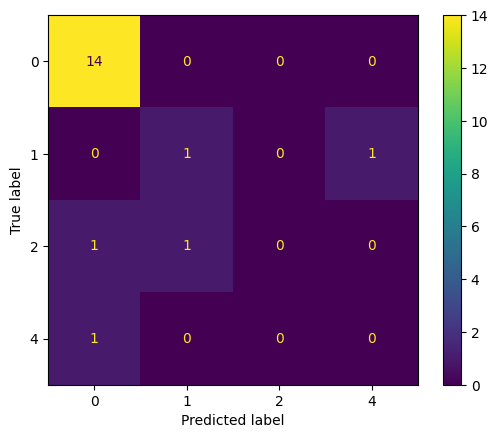

In [81]:
ConfusionMatrixDisplay.from_predictions(test_set['label'],nb_we.predict(scaler.transform(test_features_we)))

Evaluation of accuracy could be done using the standard accuracy metric 

In [82]:
accuracy_score(test_set['label'],nb_we.predict(scaler.transform(test_features_we)))

0.7894736842105263

In [83]:
balanced_accuracy_score(test_set['label'],nb_we.predict(scaler.transform(test_features_we)))

0.375

Interestingly the standard accuracy seems to have increased while the balanced accuracy decreased

# Large Language Models

## Preprocessing the data

Creating an evaluation set for LLM training

In [132]:
train_set_hf, eval_set_hf = train_test_split(train_set, test_size=0.2, random_state=1)

Combining the line items in boq_details into a single string

In [134]:
dataset = {'train':[{'text':text, 'label':label} for text, label in zip(train_set_hf['features'],train_set_hf['label'])], 'test':[{'text':text, 'label':label} for text, label in zip(eval_set_hf['features'],eval_set_hf['label'])]}

## Tokenizing the dataset for using the BERT tokenizer

In [54]:
from transformers import AutoTokenizer

In [55]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [137]:
def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", truncation = True)

In [138]:
import copy

In [139]:
tokenized_dataset = {}
tokenized_dataset['train'] = []
for item in dataset['train']:
    #print(item)
    updateditem = copy.deepcopy(item)
    tokenized = tokenize_function(item['text'])
    updateditem.update(tokenized)
    tokenized_dataset['train'].append(updateditem)

In [140]:
tokenized_dataset['test'] = []
for item in dataset['test']:
    #print(item)
    updateditem = copy.deepcopy(item)
    tokenized = tokenize_function(item['text'])
    updateditem.update(tokenized)
    tokenized_dataset['test'].append(updateditem)

Picklingdata

In [141]:
import pickle

In [142]:
hf_data = 'pickledata'
outfile = open(hf_data, 'wb')
pickle.dump(tokenized_dataset, outfile)
outfile.close()

## Training

It is recommended that one runs the following steps on GPU.
The model has been saved in the bert folder and loaded in the next section

In [144]:
from transformers import AutoModelForSequenceClassification

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
import numpy as np
import evaluate
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
modelpath = 'bert'

In [ ]:
trainer.save_model(modelpath)

# Evaluating model trained on google colab

In [57]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('bert/', num_labels=5)

In [58]:
from transformers import pipeline

In [59]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [61]:
predictions = []
for item, label in zip(test_set['features'], test_set['label'].values):
    if len(item)>512:
        data = item[:512]
    else:
        data = item
    predictions.append(classifier(data)[0]['label'])

In [62]:
final_predictions = [int(item.lstrip('LABEL_')) for item in predictions]

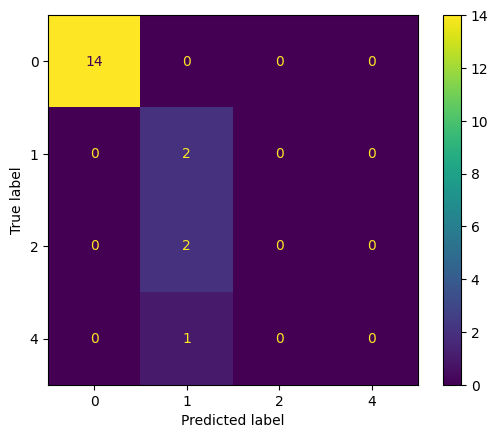

In [64]:
ConfusionMatrixDisplay.from_predictions(test_set['label'],final_predictions)

In [65]:
accuracy_score(test_set['label'],final_predictions)

0.8421052631578947

In [66]:
balanced_accuracy_score(test_set['label'],final_predictions)

0.5

It appears that both the standard accuracy and the balanced accuracy have improved on using the large language model